In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
csv_file = '/content/drive/MyDrive/Colab Notebooks/SEP740/finalproject/Dataset_GDrive_Upload_Guide/Dataset_GDrive_Upload_Guide/dataset/labeled_anomalies.csv'  #change the path based on your google drive directory
os.path.exists(csv_file)

Mounted at /content/drive


True

In [ ]:
csv_file = '/content/drive/MyDrive/Colab Notebooks/SEP740/finalproject/Dataset_GDrive_Upload_Guide/Dataset_GDrive_Upload_Guide/dataset/labeled_anomalies.csv'

import os
print(os.path.exists(csv_file))

# read CSV
import pandas as pd
df_anomalies = pd.read_csv(csv_file)
df_anomalies.head()

True


,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Paths
train_data_path = "/content/drive/MyDrive/Colab Notebooks/SEP740/finalproject/Dataset_GDrive_Upload_Guide/Dataset_GDrive_Upload_Guide/dataset/data/data/train/P-1.npy"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/SEP740/finalproject/Dataset_GDrive_Upload_Guide/Dataset_GDrive_Upload_Guide/dataset/data/data/test/P-1.npy"
csv_file = "/content/drive/MyDrive/Colab Notebooks/SEP740/finalproject/Dataset_GDrive_Upload_Guide/Dataset_GDrive_Upload_Guide/dataset/labeled_anomalies.csv"


train_data = np.load(train_data_path)
test_data = np.load(test_data_path)

# Find columns with nonzero values
train_nonzero_columns = np.where(train_data.any(axis=0))[0]
test_nonzero_columns = np.where(test_data.any(axis=0))[0]


print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)


print("Train data's columns with nonzero values:", train_nonzero_columns)
print("Test data's columns with nonzero values:", test_nonzero_columns)
print("Total count of Train data's columns with nonzero values:", len(train_nonzero_columns))
print("Total count of Test data's columns with nonzero values:", len(test_nonzero_columns))



train_data shape:  (2872, 25)
test_data shape:  (8505, 25)
Train data's columns with nonzero values: [ 0  1  2  3  5  6  7  9 11 13 14 17 18 19 21 22]
Test data's columns with nonzero values: [ 0  1  2  3  5  6  7  8  9 11 12 13 14 17 18 19 21 22]
Total count of Train data's columns with nonzero values: 16
Total count of Test data's columns with nonzero values: 18


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
def create_sequences(data, window_size):
    seqs = []
    for i in range(len(data) - window_size + 1):
        seqs.append(data[i : i + window_size])
    return np.array(seqs)


window_size = 30
X_train_seq = create_sequences(train_data, window_size)
X_test_seq = create_sequences(test_data, window_size)

timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]



In [ ]:
n_timesteps, n_features = X_train_seq.shape[1], X_train_seq.shape[2]
latent_dim = 32

In [ ]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
inputs = Input(shape=(n_timesteps, n_features))


# 2) Encoder with dropout + L2 on both kernel & recurrent weights
x = LSTM(128,
         activation='relu',
         return_sequences=True,
         dropout=0.1,                 # drop 20% of inputs to this LSTM
         recurrent_dropout=0.1,       # drop 20% of recurrent state
         kernel_regularizer=l2(1e-4),
         recurrent_regularizer=l2(1e-4)
)(inputs)
x = LSTM(64,
         activation='relu',
         return_sequences=True,
         dropout=0.1,
         recurrent_dropout=0.1,
         kernel_regularizer=l2(1e-4),
         recurrent_regularizer=l2(1e-4)
)(x)
encoded = LSTM(latent_dim,
               activation='relu',
               return_sequences=False,
               dropout=0.1,
               recurrent_dropout=0.1,
               kernel_regularizer=l2(1e-4),
               recurrent_regularizer=l2(1e-4)
)(x)

# 3) Bottleneck → expand back out
decoded = RepeatVector(n_timesteps)(encoded)

# 4) Decoder (mirrors the encoder)
x = LSTM(latent_dim,
         activation='relu',
         return_sequences=True,
         dropout=0.1,
         recurrent_dropout=0.1,
         kernel_regularizer=l2(1e-4),
         recurrent_regularizer=l2(1e-4)
)(decoded)
x = LSTM(64,
         activation='relu',
         return_sequences=True,
         dropout=0.1,
         recurrent_dropout=0.1,
         kernel_regularizer=l2(1e-4),
         recurrent_regularizer=l2(1e-4)
)(x)
x = LSTM(128,
         activation='relu',
         return_sequences=True,
         dropout=0.1,
         recurrent_dropout=0.1,
         kernel_regularizer=l2(1e-4),
         recurrent_regularizer=l2(1e-4)
)(x)

# 5) Final reconstruction layer (with L2)
outputs = TimeDistributed(
    Dense(n_features, kernel_regularizer=l2(1e-4))
)(x)

model = Model(inputs, outputs)

optimizer = Adam(
    learning_rate=1e-3
)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 25)         │         3,225 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,865 (1.05 MB)

 Trainable params: 275,865 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputs = Input(shape=(n_timesteps, n_features))


# Encoder_Layers
#encoded = LSTM(256, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(encoded)

# Bottleneck → repeat
decoded = RepeatVector(n_timesteps)(encoded)

# Decoder_Layers
decoded = LSTM(latent_dim, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
#decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
# (optional) you can add a TimeDistributed Dense for further reconstruction:
outputs = TimeDistributed(Dense(n_features))(decoded)




In [ ]:

# Encoder_Layers

encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(encoded)

# Bottleneck → repeat
decoded = RepeatVector(n_timesteps)(encoded)

# Decoder_Layers
decoded = LSTM(latent_dim, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)

outputs = TimeDistributed(Dense(n_features))(decoded)

In [ ]:
ae = Model(inputs, outputs)
ae.compile(optimizer='adam', loss='mse')

ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 25)         │         3,225 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,865 (1.05 MB)

 Trainable params: 275,865 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = ae.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - loss: 0.0290 - val_loss: 0.0289
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - loss: 0.0218 - val_loss: 0.0261
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 0.0196 - val_loss: 0.0230
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0171 - val_loss: 0.0189
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 0.0144 - val_loss: 0.0178
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 0.0132 - val_loss: 0.0169
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - loss: 0.0123 - val_loss: 0.0166
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - loss: 0.0120 - val_loss: 0.0169
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.0126 - val_loss: 0.0159
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 0.0109 - val_loss: 0.0162
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 0.0109 - val_loss: 0.0154
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 2

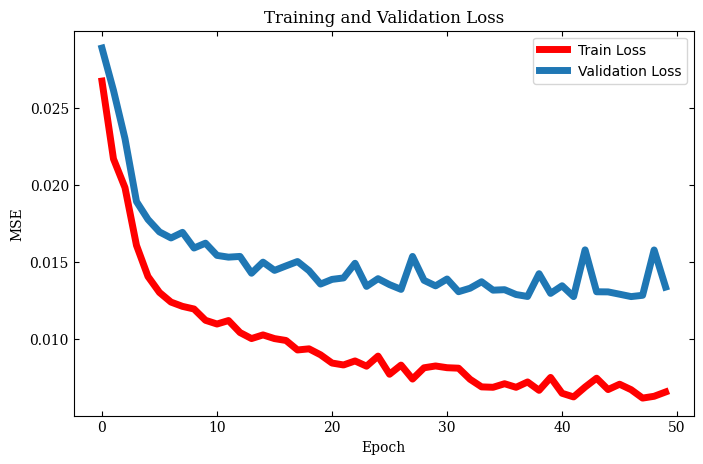

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Reset to default rcParams
mpl.rcParams.update(mpl.rcParamsDefault)

# Plot on the defined axis
ax.plot(history.history['loss'], label='Train Loss', linewidth= 5, color= 'red')
ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=5)

# Axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')

# Style and legend
ax.legend()
ax.grid(False)

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
#ax.tick_params(axis="both", which="major", labelsize=12)

# Save as editable PDF with transparent background and custom DPI
fig.savefig(
    '/content/drive/MyDrive/training_loss_plot_LSTM_baseline.pdf',
    format='pdf',
    transparent=True,
    dpi=1200  # High-resolution for publication
)

fig.savefig(
    '/content/drive/MyDrive/training_loss_plot_LSTM_baseline.png',
    format='png',
    transparent=True,
    dpi=900  # High-resolution for publication
)

import pandas as pd

# Create a DataFrame with both loss and val_loss
df_history = pd.DataFrame({
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
df_history.index.name = 'Epoch'

# Save to Excel
excel_path = "/content/drive/MyDrive/loss_history_LSTM_baseline.xlsx"
df_history.to_excel(excel_path)


plt.show()


### Anomaly Detection will involve predicting (reconstructing) the test data, defining a threshold and computing the reconstruction error

In [ ]:
X_train_pred = ae.predict(X_train_seq)


# Anomaly detection on the test set
X_test_pred = ae.predict(X_test_seq)
mse_test = np.mean((X_test_seq - X_test_pred)**2, axis=(1,2))

# We set threshold using 95 percentile
threshold = np.percentile(mse_test, 95)
print(f"Chosen MSE threshold: {threshold:.4f}")


y_pred = (mse_test > threshold).astype(int)


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
Chosen MSE threshold: 0.0253


In [ ]:
print(y_pred)

[1 1 1 ... 0 0 0]


In [ ]:
import ast
# Display unique telemetry channels
print(df_anomalies['chan_id'].unique())

# Check anomalies for a specific channel
df_anomalies[df_anomalies['chan_id'] == 'P-1']

known_anomalies = ast.literal_eval(
    df_anomalies[df_anomalies['chan_id'] == 'P-1']['anomaly_sequences'].values[0]
)



['P-1' 'S-1' 'E-1' 'E-2' 'E-3' 'E-4' 'E-5' 'E-6' 'E-7' 'E-8' 'E-9' 'E-10'
 'E-11' 'E-12' 'E-13' 'A-1' 'D-1' 'P-2' 'P-3' 'D-2' 'D-3' 'D-4' 'A-2'
 'A-3' 'A-4' 'G-1' 'G-2' 'D-5' 'D-6' 'D-7' 'F-1' 'P-4' 'G-3' 'T-1' 'T-2'
 'D-8' 'D-9' 'F-2' 'G-4' 'T-3' 'D-11' 'D-12' 'B-1' 'G-6' 'G-7' 'P-7' 'R-1'
 'A-5' 'A-6' 'A-7' 'D-13' 'A-8' 'A-9' 'F-3' 'M-6' 'M-1' 'M-2' 'S-2' 'P-10'
 'T-4' 'T-5' 'F-7' 'M-3' 'M-4' 'M-5' 'P-15' 'C-1' 'C-2' 'T-12' 'T-13'
 'F-4' 'F-5' 'D-14' 'T-9' 'P-14' 'T-8' 'P-11' 'D-15' 'D-16' 'M-7' 'F-8']


In [ ]:
# Get the indices of points above the threshold
detected_anomalies = np.where(mse_test > threshold)[0]


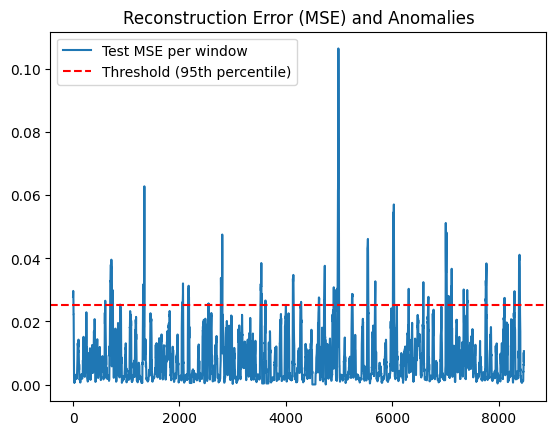

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mse_test, label='Test MSE per window')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold (95th percentile)')
plt.legend()
plt.title("Reconstruction Error (MSE) and Anomalies")
plt.show()

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
ax.tick_params(axis="both", which="major", labelsize=12)

# Save as editable PDF with transparent background and custom DPI
fig.savefig(
    '/content/drive/MyDrive/Reconstruction Error (MSE) and Anomalies_LSTM_8.pdf',
    format='pdf',
    transparent=True,
    dpi=1200  # High-resolution for publication
)

fig.savefig(
    '/content/drive/MyDrive/loss_plot_LSTM_8.png',
    format='png',
    dpi=900,  # 300+ is good for print, 150+ for screen
    bbox_inches='tight'
)

In [ ]:
# Initialize counters
tp_intervals = 0   # Number of correctly detected anomaly intervals
fp_points = 0      # Number of false positive points (predicted anomaly points not in any true interval)

# Create binary mask of known anomaly regions (for fast FP lookup)
mask = np.zeros(len(mse_test), dtype=bool)
for start, end in known_anomalies:
    mask[start:end+1] = True

# Count true positives: if a predicted point falls within an interval, it's considered TP
for start, end in known_anomalies:
    if np.any((detected_anomalies >= start) & (detected_anomalies <= end)):
        tp_intervals += 1

# Count false positives: predicted points not falling inside any true interval
fp_points = np.sum(~mask[detected_anomalies])

# Count false negatives: true intervals that are not detected at all
fn_intervals = len(known_anomalies) - tp_intervals

# Compute metrics
precision = tp_intervals / (tp_intervals + fp_points) if (tp_intervals + fp_points) > 0 else 0
recall = tp_intervals / (tp_intervals + fn_intervals) if (tp_intervals + fn_intervals) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

# Print results
print(f"✅ Detected Anomaly Intervals (TP): {tp_intervals}")
print(f"❌ Missed Anomaly Intervals (FN): {fn_intervals}")
print(f"⚠️ False Positive Points (FP): {fp_points}")
print(f"📌 Precision: {precision:.3f}")
print(f"📈 Recall: {recall:.3f}")
print(f"🥇 F1-score: {f1:.3f}")

✅ Detected Anomaly Intervals (TP): 3
❌ Missed Anomaly Intervals (FN): 0
⚠️ False Positive Points (FP): 373
📌 Precision: 0.008
📈 Recall: 1.000
🥇 F1-score: 0.016


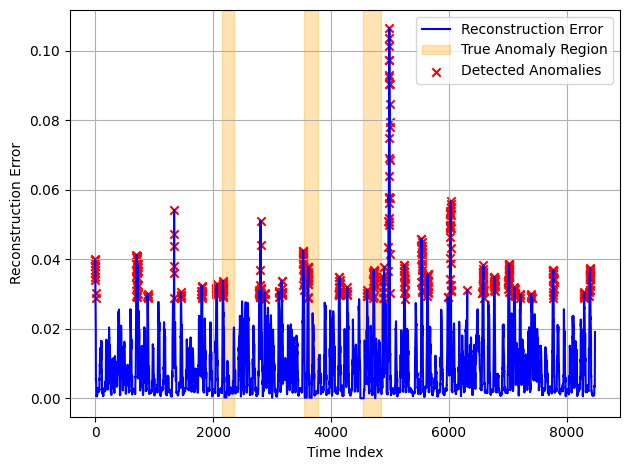

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Plot reconstruction error or original signal
plt.plot(mse_test, label='Reconstruction Error', color='blue')

# Overlay known anomaly regions
for start, end in known_anomalies:
    plt.axvspan(start, end, color='orange', alpha=0.3, label='True Anomaly Region')

# Overlay detected anomaly points
plt.scatter(detected_anomalies, mse_test[detected_anomalies],
            color='red', marker='x', label='Detected Anomalies')

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
ax.tick_params(axis="both", which="major", labelsize=12)

# Make sure the true anomaly region doesn't have duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
#ax.tick_params(axis="both", which="major", labelsize=12)

# Save as editable PDF with transparent background and custom DPI
fig.savefig(
    '/content/drive/MyDrive/Anomaly_Detection_plot_FCN_baseline.pdf',
    format='pdf',
    transparent=True,
    dpi=1200  # High-resolution for publication
)

fig.savefig(
    '/content/drive/MyDrive/Anomaly_Detection_LSTM_baseline.png',
    format='png',
    transparent=True,
    dpi=900  # High-resolution for publication
)

plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
#plt.title('Anomaly Detection Results')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Example: y_true = [0, 0, 1, 0, 1, 0, ...]
# anomaly_scores = model.predict(X_test)  → then compute reconstruction error → shape (num_samples,)

T = 8476
SEQ_LEN = 30

# Create binary ground truth label for each time step
true_mask = np.zeros(T, dtype=int)

for start, end in known_anomalies:
    true_mask[start:end+1] = 1  # mark anomaly regions

def create_sequence_labels(mask, seq_len):
    labels = []
    for i in range(len(mask) - seq_len):
        window = mask[i:i+seq_len]
        labels.append(1 if np.any(window) else 0)
    return np.array(labels)

anomaly_true = create_sequence_labels(true_mask, SEQ_LEN)


mse_test_1 = mse_test[SEQ_LEN:]  # now shape = 8476 - SEQ_LEN = 8426


from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

# ROC
fpr, tpr, _ = roc_curve(anomaly_true, mse_test_1)
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, _ = precision_recall_curve(anomaly_true, mse_test_1)
pr_auc = average_precision_score(anomaly_true, mse_test_1)




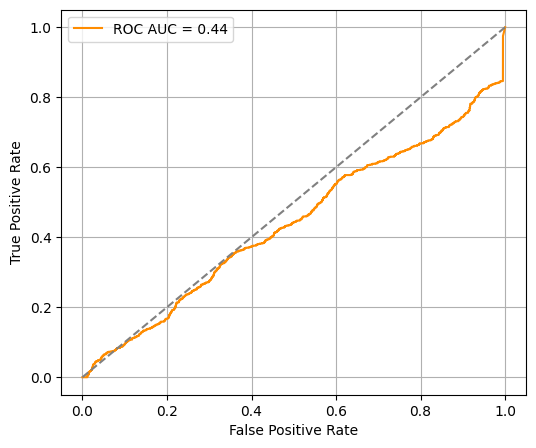

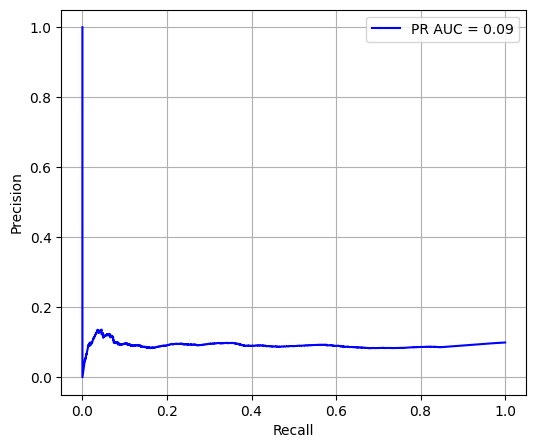

Saved ROC to: /content/drive/MyDrive/ROC_Curve_LSTM_baseline.pdf
Saved PR to: /content/drive/MyDrive/PR_Curve_LSTM_baseline.pdf


In [ ]:
# === ROC ===
fig_roc = plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# Save ROC as PDF
roc_path = '/content/drive/MyDrive/ROC_Curve_LSTM_baseline.pdf'
fig_roc.savefig(roc_path, format='pdf', transparent=True, dpi=1200)

roc_path_png = '/content/drive/MyDrive/ROC_Curve_LSTM_baseline.png'
fig_roc.savefig(roc_path_png, format='png', transparent=True, dpi=900)
plt.show()


# === PR ===
fig_pr = plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

# Save PR as PDF
pr_path = '/content/drive/MyDrive/PR_Curve_LSTM_baseline.pdf'
fig_pr.savefig(pr_path, format='pdf', transparent=True, dpi=1200)

pr_path_png = '/content/drive/MyDrive/PR_Curve_LSTM_baseline.png'
fig_pr.savefig(pr_path_png, format='png', transparent=True, dpi=900)

plt.show()



print("Saved ROC to:", roc_path)
print("Saved PR to:", pr_path)


## Apending results and traking metrics for documentation and comparison

In [ ]:
results = []
results.append({
    "latent_dim": latent_dim,
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "pr_auc": pr_auc,
    "mse_loss_val": history.history['val_loss'][-1],
    "mse_loss_train": history.history['loss'][-1]
})

# --- Display Results ---
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

   latent_dim        f1                                          precision  \
0          32  0.015625  [0.09921856500118399, 0.09761620977353992, 0.0...   

                                              recall    pr_auc  mse_loss_val  \
0  [1.0, 0.977326968973747, 0.9749403341288783, 0...  0.091197      0.012726   

   mse_loss_train  
0        0.006203  



## Using Only_Dense_Layers

In [ ]:
X_train_dense = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1] * X_train_seq.shape[2]))
#X_val_dense   = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
X_test_dense  = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1] * X_test_seq.shape[2]))


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_train_dense.shape[1]

# Encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(inputs)
encoded = Dense(64, activation='relu')(encoded)

# Decoder
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
outputs = Dense(input_dim)(decoded)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 750)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        96,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 750)            │        96,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,646 (834.55 KB)

 Trainable params: 213,646 (834.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_dense, X_train_dense,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0299 - val_loss: 0.0226
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0175
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0165
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0155
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0147
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0141
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0136
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0131
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0127
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0123
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0119
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_l

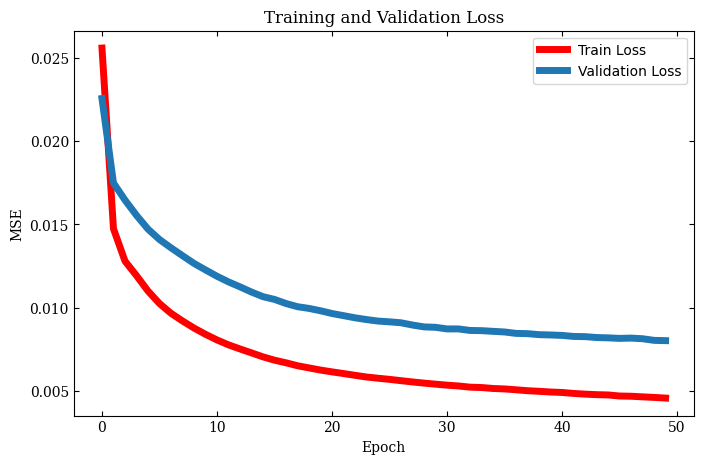

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Reset to default rcParams
mpl.rcParams.update(mpl.rcParamsDefault)

# Plot on the defined axis
ax.plot(history.history['loss'], label='Train Loss', linewidth= 5, color= 'red')
ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=5)

# Axis labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')

# Style and legend
ax.legend()
ax.grid(False)

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
#ax.tick_params(axis="both", which="major", labelsize=12)

# Save as editable PDF with transparent background and custom DPI
fig.savefig(
    '/content/drive/MyDrive/training_loss_plot_FCN_baseline.pdf',
    format='pdf',
    transparent=True,
    dpi=1200  # High-resolution
)

fig.savefig(
    '/content/drive/MyDrive/training_loss_plot_FCN_baseline.png',
    format='png',
    transparent=False,
    dpi=900  # High-resolution
)

plt.show()

import pandas as pd

# Create a DataFrame with both loss and val_loss
df_history = pd.DataFrame({
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
df_history.index.name = 'Epoch'

# Save to Excel
excel_path = "/content/drive/MyDrive/loss_history_dense.xlsx"
df_history.to_excel(excel_path)




In [ ]:
#X_train_pred = ae.predict(X_train_seq)



# Anomaly detection on the test set
X_test_pred_dense = model.predict(X_test_dense)
mse_test = np.mean((X_test_dense - X_test_pred_dense)**2, axis=(1))

# We set threshold using 95 percentile
threshold = np.percentile(mse_test, 95)
print(f"Chosen MSE threshold: {threshold:.4f}")


y_pred = (mse_test > threshold).astype(int)


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Chosen MSE threshold: 0.0183


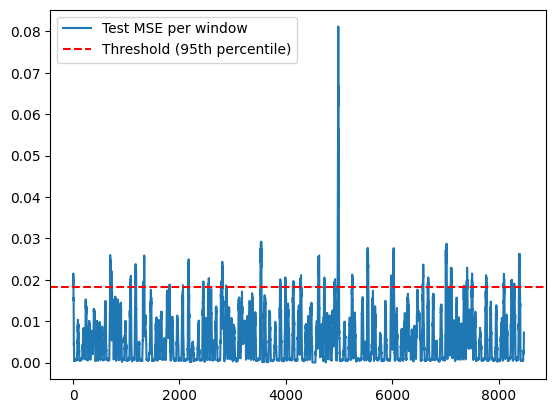

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mse_test, label='Test MSE per window')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold (95th percentile)')
plt.legend()
#plt.title("Reconstruction Error (MSE) and Anomalies")
plt.show()

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
ax.tick_params(axis="both", which="major", labelsize=12)


fig.savefig(
    '/content/drive/MyDrive/Reconstruction Error (MSE) and Anomalies_FCN_baseline.pdf',
    format='pdf',
    transparent=True,
    dpi=1200
)

fig.savefig(
    '/content/drive/MyDrive/loss_plot_dense.png',
    format='png',
    dpi=900,
    bbox_inches='tight'
)

In [ ]:
# Initialize counters
tp_intervals = 0   # Number of correctly detected anomaly intervals
fp_points = 0      # Number of false positive points (predicted anomaly points not in any true interval)

# Create binary mask of known anomaly regions (for fast FP lookup)
mask = np.zeros(len(mse_test), dtype=bool)
for start, end in known_anomalies:
    mask[start:end+1] = True

# Count true positives: if a predicted point falls within an interval, it's considered TP
for start, end in known_anomalies:
    if np.any((detected_anomalies >= start) & (detected_anomalies <= end)):
        tp_intervals += 1

# Count false positives: predicted points not falling inside any true interval
fp_points = np.sum(~mask[detected_anomalies])

# Count false negatives: true intervals that are not detected at all
fn_intervals = len(known_anomalies) - tp_intervals

# Compute metrics
precision = tp_intervals / (tp_intervals + fp_points) if (tp_intervals + fp_points) > 0 else 0
recall = tp_intervals / (tp_intervals + fn_intervals) if (tp_intervals + fn_intervals) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

# Print results
print(f"✅ Detected Anomaly Intervals (TP): {tp_intervals}")
print(f"❌ Missed Anomaly Intervals (FN): {fn_intervals}")
print(f"⚠️ False Positive Points (FP): {fp_points}")
print(f"📌 Precision: {precision:.3f}")
print(f"📈 Recall: {recall:.3f}")
print(f"🥇 F1-score: {f1:.3f}")

✅ Detected Anomaly Intervals (TP): 3
❌ Missed Anomaly Intervals (FN): 0
⚠️ False Positive Points (FP): 371
📌 Precision: 0.008
📈 Recall: 1.000
🥇 F1-score: 0.016


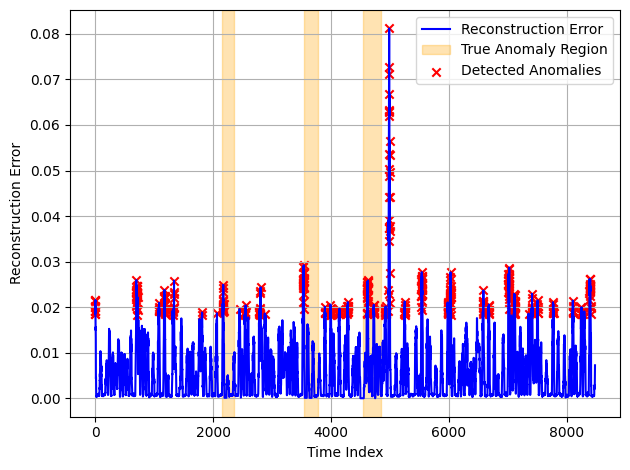

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Get the indices of points above the threshold
detected_anomalies = np.where(mse_test > threshold)[0]

# Plot reconstruction error or original signal
plt.plot(mse_test, label='Reconstruction Error', color='blue')

# Overlay known anomaly regions
for start, end in known_anomalies:
    plt.axvspan(start, end, color='orange', alpha=0.3, label='True Anomaly Region')

# Overlay detected anomaly points
plt.scatter(detected_anomalies, mse_test[detected_anomalies],
            color='red', marker='x', label='Detected Anomalies')



# Make sure the true anomaly region doesn't have duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

# Customize ticks
ax.tick_params(
    axis='both',      # apply to x and y axis
    which='both',     # apply to major and minor ticks
    direction='in',   # draw ticks inward
    top=True,         # ticks on top edge
    right=True        # ticks on right edge
)
#ax.tick_params(axis="both", which="major", labelsize=12)

# Save as editable PDF with transparent background and custom DPI
fig.savefig(
    '/content/drive/MyDrive/Anomaly_detection_results_dense.pdf',
    format='pdf',
    transparent=True,
    dpi=1200  # High-resolution for publication
)

fig.savefig(
    '/content/drive/MyDrive/Anomaly_detection_results_dense.png',
    format='png',
    transparent=True,
    dpi=900  # High-resolution for publication
)



plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
#plt.title('Anomaly Detection Results')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("labels:", len(anomaly_true))
print("scores:", len(mse_test))


labels: 8446
scores: 8476


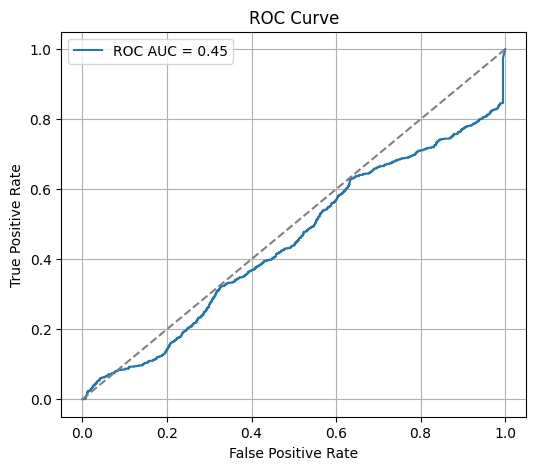

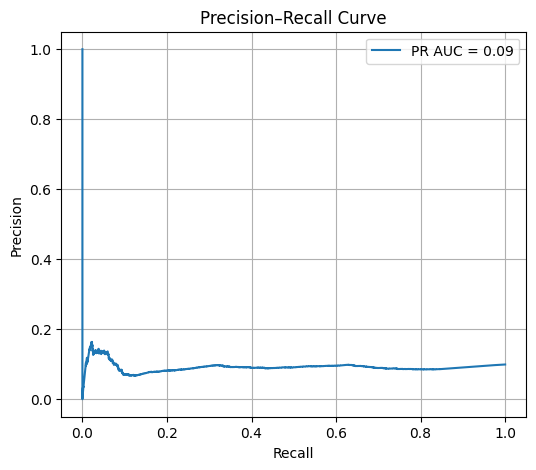

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

T = 8476
SEQ_LEN = 30

# Building true_mask (shape T,)
true_mask = np.zeros(T, dtype=int)
for start, end in known_anomalies:
    true_mask[start:end+1] = 1

# Build seq‑level labels (shape T‑SEQ_LEN,)
def create_sequence_labels(mask, seq_len):
    labels = []
    for i in range(len(mask) - seq_len):
        labels.append(int(mask[i : i + seq_len].any()))
    return np.array(labels)

anomaly_true = create_sequence_labels(true_mask, SEQ_LEN)

# 3) trim your MSE vector to the same length
mse_test_dense = mse_test[SEQ_LEN:]

# 4) compute ROC & PR
fpr, tpr, _ = roc_curve(anomaly_true, mse_test_dense)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(anomaly_true, mse_test_dense)
pr_auc = average_precision_score(anomaly_true, mse_test_dense)


# ROC figure
fig_roc = plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# save it
fig_roc.savefig(
    '/content/drive/MyDrive/ROC_dense.pdf',
    format='pdf',
    transparent=True,
    dpi=1200
)
fig_roc.savefig(
    '/content/drive/MyDrive/ROC_dense.png',
    format='png',
    transparent=True,
    dpi=900
)

# PR figure
fig_pr = plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)

# save it
fig_pr.savefig(
    '/content/drive/MyDrive/PR_dense.pdf',
    format='pdf',
    transparent=True,
    dpi=1200
)
fig_pr.savefig(
    '/content/drive/MyDrive/PR_dense.png',
    format='png',
    transparent=True,
    dpi=900
)

plt.show()
